In [1]:
import pandas as pd
import numpy as np
import re

from sklearn.cluster import DBSCAN, KMeans
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import silhouette_score

# import kmeans1d
'''
kmeans1d

A Python library with an implementation of k-means clustering on 1D data, based on the algorithm in (Xiaolin 1991), as presented in section 2.2 of (Gronlund et al., 2017).

Globally optimal k-means clustering is NP-hard for multi-dimensional data. Lloyd's algorithm is a popular approach for finding a locally optimal solution. For 1-dimensional data, there are polynomial time algorithms. The algorithm implemented here is a O(kn + n log n) dynamic programming algorithm for finding the globally optimal k clusters for n 1D data points.

The code is written in C++, and wrapped with Python.
'''

# import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# shape (381109, 11)
data_1 = pd.read_csv('datasets/d1.csv')
data_1 = data_1.drop(['id'], axis=1)

data_2 = pd.read_csv('datasets/d2.csv')

In [3]:
data_1

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0
...,...,...,...,...,...,...,...,...,...,...,...
381104,Male,74,1,26.0,1,1-2 Year,No,30170.0,26.0,88,0
381105,Male,30,1,37.0,1,< 1 Year,No,40016.0,152.0,131,0
381106,Male,21,1,30.0,1,< 1 Year,No,35118.0,160.0,161,0
381107,Female,68,1,14.0,0,> 2 Years,Yes,44617.0,124.0,74,0


In [4]:
from itertools import combinations
columns_name = ['a','b','c']
combX = []
comb_max_depth = 2
for idx, _ in enumerate(columns_name):
    if comb_max_depth and comb_max_depth == idx:
        break
    combX.extend(list(combinations(columns_name, idx + 1)))

sorted(combX, key=len)

[('a',), ('b',), ('c',), ('a', 'b'), ('a', 'c'), ('b', 'c')]

In [5]:
data_1.nunique()

Gender                      2
Age                        66
Driving_License             2
Region_Code                53
Previously_Insured          2
Vehicle_Age                 3
Vehicle_Damage              2
Annual_Premium          48838
Policy_Sales_Channel      155
Vintage                   290
Response                    2
dtype: int64

0    81
1    19
Name: Response, dtype: int64

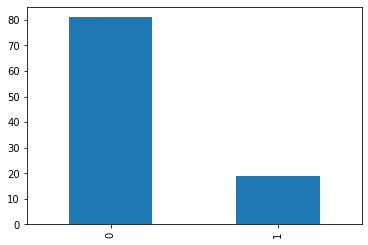

In [6]:
data_1 = data_1.sample(100)

data_1['Response'].value_counts().plot(kind='bar')
data_1['Response'].value_counts()

In [7]:
data_1.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
144473,Male,27,1,28.0,0,< 1 Year,Yes,2630.0,124.0,109,1
86006,Female,23,1,18.0,0,< 1 Year,No,28408.0,152.0,32,0
25462,Male,41,1,46.0,1,1-2 Year,No,41498.0,124.0,71,0
272301,Male,28,1,8.0,0,< 1 Year,Yes,2630.0,157.0,195,0
225202,Female,72,1,28.0,1,1-2 Year,No,37562.0,26.0,217,0


In [8]:
top_n = 10 
likely_dis = []

# check if attribute is continuous or discrete dataframe 
for var in data_1.columns:
    # Find the ratio of number of unique values to the total number of unique values. Something like the following
    # if 1.*data_1[var].nunique()/data_1[var].count() > 0.5:

    # Check if the top n unique values account for more than a certain proportion of all values
    if 1.*data_1[var].value_counts(normalize=True).head(top_n).sum() < 0.5:
        likely_dis.append(var)
        
likely_dis

['Annual_Premium', 'Vintage']

In [9]:
# Scaleing is a process of transforming data into a stander values so we can get the best of it
# 
# https://stats.stackexchange.com/questions/89809/is-it-important-to-scale-data-before-clustering
scaler =  StandardScaler()
scaled_column_names = [x for x in likely_dis if x.lower() not in ['id']]
data_cluster = data_1[scaled_column_names].copy()
scaled_data = scaler.fit_transform(data_cluster)

data_scaled = data_1.copy()
data_scaled[scaled_column_names] = scaled_data
data_scaled

# [['Vintage','Annual_Premium']]
# scaler.inverse_transform([[0.748795	, 0.574539]])

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
144473,Male,27,1,28.0,0,< 1 Year,Yes,-1.609761,124.0,-0.393959,1
86006,Female,23,1,18.0,0,< 1 Year,No,-0.002250,152.0,-1.346088,0
25462,Male,41,1,46.0,1,1-2 Year,No,0.814040,124.0,-0.863841,0
272301,Male,28,1,8.0,0,< 1 Year,Yes,-1.609761,157.0,0.669458,0
225202,Female,72,1,28.0,1,1-2 Year,No,0.568592,26.0,0.941495,0
...,...,...,...,...,...,...,...,...,...,...,...
211736,Female,46,1,31.0,0,1-2 Year,Yes,-1.609761,124.0,1.881259,1
354171,Female,37,1,8.0,0,1-2 Year,Yes,-0.001813,26.0,-1.296627,1
224985,Female,46,1,9.0,1,1-2 Year,No,-0.153535,26.0,-0.665996,0
90559,Female,26,1,11.0,1,< 1 Year,No,0.424790,152.0,-1.210070,0


In [10]:
from scipy import stats
data_scaled = data_scaled[(np.abs(stats.zscore(data_scaled.Annual_Premium)) < 3)]
data_scaled

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
144473,Male,27,1,28.0,0,< 1 Year,Yes,-1.609761,124.0,-0.393959,1
86006,Female,23,1,18.0,0,< 1 Year,No,-0.002250,152.0,-1.346088,0
25462,Male,41,1,46.0,1,1-2 Year,No,0.814040,124.0,-0.863841,0
272301,Male,28,1,8.0,0,< 1 Year,Yes,-1.609761,157.0,0.669458,0
225202,Female,72,1,28.0,1,1-2 Year,No,0.568592,26.0,0.941495,0
...,...,...,...,...,...,...,...,...,...,...,...
211736,Female,46,1,31.0,0,1-2 Year,Yes,-1.609761,124.0,1.881259,1
354171,Female,37,1,8.0,0,1-2 Year,Yes,-0.001813,26.0,-1.296627,1
224985,Female,46,1,9.0,1,1-2 Year,No,-0.153535,26.0,-0.665996,0
90559,Female,26,1,11.0,1,< 1 Year,No,0.424790,152.0,-1.210070,0


In [400]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

X = np.array(data_scaled.Annual_Premium.tolist()).reshape(-1,1)

for n_clusters in range(3,9):
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

KeyboardInterrupt: 

[5999.999999999979, 1595.7184828307988, 602.6535070181575, 356.47743944212414, 235.84797664144438, 165.79979997720045, 123.11796475192453, 95.95446027697153, 77.97615875097586]


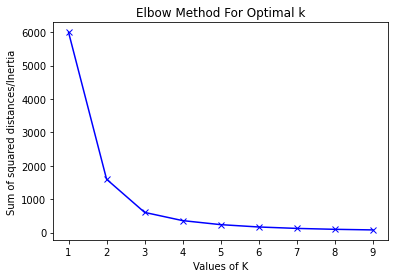

[6000.0000000000255, 2639.1291198006475, 1301.7383089951502, 801.9835068875364, 534.5522887807397, 380.39047045367664, 258.21613045674667, 195.50048974992293, 141.96547414107025]


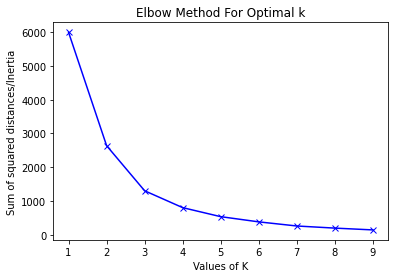

[6000.000000000007, 1491.238436650119, 667.6539033905401, 375.7359924771491, 242.98412890055897, 166.93469305833383, 120.69636417949894, 92.88143156377711, 72.35903712810529]


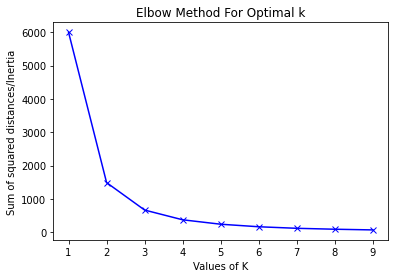

In [317]:
K = range(1,10)
for att in scaled_column_names:
    Sum_of_squared_distances = []
    for num_clusters in K :
        kmeans = KMeans(n_clusters=num_clusters)
        kmeans.fit(np.array(data_scaled[att].tolist()).reshape(-1, 1))
        Sum_of_squared_distances.append(kmeans.inertia_)
    print(Sum_of_squared_distances)
    plt.plot(K,Sum_of_squared_distances,"bx-")
    plt.xlabel("Values of K") 
    plt.ylabel("Sum of squared distances/Inertia") 
    plt.title("Elbow Method For Optimal k")
    plt.show()

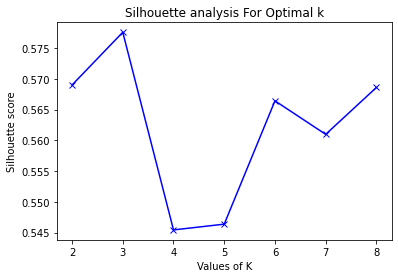

In [321]:
range_n_clusters = range(2,9)
silhouette_avg = []
for num_clusters in range_n_clusters:
    # initialize kmeans
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(np.array(scaled_data.tolist()).reshape(-1, 1))
    cluster_labels = kmeans.labels_

    # silhouette score
    silhouette_avg.append(silhouette_score(scaled_data.reshape(-1, 1), cluster_labels))

plt.plot(range_n_clusters, silhouette_avg, 'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k')
plt.show()

In [241]:
%%time


clustering = DBSCAN(eps=0.5, min_samples=4).fit(
# clustering = KMeans(n_clusters=4).fit(
        np.array(data_1['months_as_customer'].tolist()).reshape(-1, 1)
    )
clustering1 = DBSCAN(eps=0.5, min_samples=4).fit(
# clustering = KMeans(n_clusters=4).fit(
        np.array(data_1['total_claim_amount'].tolist()).reshape(-1, 1)
    )

p = pd.DataFrame(zip(clustering.labels_, clustering1.labels_), columns=['months_as_customer', 'total_claim_amount'])
p.nunique()

CPU times: total: 31.2 ms
Wall time: 18 ms


months_as_customer    98
total_claim_amount    12
dtype: int64

In [57]:
data_after_clsuter = data_scaled.copy()
data_after_clsuter[scaled_column_names] = scaler.inverse_transform(scaled_data)
data_after_clsuter.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
210887,210888,Female,57,1,29.0,0,1-2 Year,Yes,41112.0,26.0,20.0,0
78681,78682,Male,42,1,8.0,0,1-2 Year,Yes,2630.0,156.0,90.0,0
51839,51840,Female,29,1,21.0,1,< 1 Year,No,27799.0,152.0,28.0,0
356263,356264,Male,37,1,46.0,0,1-2 Year,Yes,22458.0,124.0,15.0,0
101819,101820,Female,30,1,28.0,0,< 1 Year,Yes,22578.0,152.0,130.0,0


In [500]:

data_cluster_sort = data_after_clsuter.copy()
data_cluster_sort['cluster'] = clustering.labels_
data_cluster_sort.sort_values(['cluster'], inplace=True)
data_cluster_sort.to_csv('data_cluster_sort.csv')
data_cluster_sort.head()

ValueError: Length of values (1000) does not match length of index (99)

In [58]:
le = LabelEncoder()
encoder_dict = dict()
data_endocded = data_scaled.copy()

for col in data_endocded:
    if col not in ['Annual_Premium', 'Vintage']:
        le = le.fit(data_endocded[col])
        data_endocded[col] = le.transform(data_endocded[col])
        encoder_dict[col] = le

np.save('encoder_dict.npy', encoder_dict)
# encoder_dict = np.load('encoder_dict.npy', allow_pickle=True).tolist()
data_endocded.to_csv('data_endocded.csv', index=False)
data_endocded = pd.read_csv('data_endocded.csv')

In [59]:
data_1.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
144473,Male,27,1,28.0,0,< 1 Year,Yes,2630.0,124.0,109,1
86006,Female,23,1,18.0,0,< 1 Year,No,28408.0,152.0,32,0
25462,Male,41,1,46.0,1,1-2 Year,No,41498.0,124.0,71,0
272301,Male,28,1,8.0,0,< 1 Year,Yes,2630.0,157.0,195,0
225202,Female,72,1,28.0,1,1-2 Year,No,37562.0,26.0,217,0


In [84]:
class RST:
    def __init__(
        self,
        data: pd.DataFrame = None,
        continuous_columns: list = [],
        decision_column_name: str = 'class',
    ):

        
        # Main variable of RST class
        self.data = data
        self.data_indiscernibility = {}
        self.continuous_columns = continuous_columns
        self.decision_column_name = decision_column_name

        # Main variable of RST process
        self.lower_approx = {}
        self.upper_approx = {}
        self.boundary_region = {}
        self.outside_region = {}
        self.U = self._list_to_set_conversion(self.data.index.values.tolist())

        # Config Variable
        self.target_sets = self.get_indiscernibility([decision_column_name])
        self.target_unique = self.data[decision_column_name].unique()
        self.target_sets_dict = {self.target_unique[idx]: ele for idx, ele in enumerate(self.target_sets[decision_column_name])}

    def get_indiscernibility(self, combination: list = []):

        def indices(lst, item):
            return [i for i, x in enumerate(lst) if x == item]

        selected_columns = self.data[combination].to_dict('list')
        data = list(zip(*selected_columns.values()))
        self.data_indiscernibility.update({
            self._create_names(combination): list(indices(data, x) for x in set(data) if data.count(x) > 1)
        })
        return self.data_indiscernibility

    def set_main_variable(self, combination: list = []):
        _c_n = self._create_names(combination)  # combination name
        combination_upper = {}
        combination_lower = {}

        for target, set in self.target_sets_dict.items():
            if _c_n not in self.data_indiscernibility:
                self.get_indiscernibility(combination)

            c = combination.copy()
            c.append(str(target))
            __c_n = self._create_names(c)

            self.lower_approx.update({__c_n: []})
            self.upper_approx.update({__c_n: []})
            self.boundary_region.update({__c_n: []})
            self.outside_region.update({__c_n: []})

            for IND in self.data_indiscernibility[_c_n]:
                if all(True if x in set else False for x in IND):
                    self.lower_approx[__c_n].extend(IND)

                if any(True if x in set else False for x in IND):
                    self.upper_approx[__c_n].extend(IND)

            combination_lower.update({__c_n: self.lower_approx[__c_n]})
            combination_upper.update({__c_n: self.upper_approx[__c_n]})

            upper = self._list_to_set_conversion(self.upper_approx[__c_n])
            lower = self._list_to_set_conversion(self.lower_approx[__c_n])
            

            self.boundary_region[__c_n].extend(
                upper - lower
            )

            self.outside_region[__c_n].extend(
                self.U - upper
            )

        return [
            combination_upper,
            combination_lower,
            self.boundary_region[__c_n],
            self.outside_region[__c_n]
        ]

    def get_dependency(self, combination: list = []):
        _, lower, _, _ = self.set_main_variable(combination)
        divider = sum([len(v) for v in lower.values()])
        dependency = divider / len(self.U)
        return [
            lower,
            dependency
        ]

    def _create_names(self, e) -> str:
        return '_'.join(e)

    def _list_to_set_conversion(self, l):
        se = set()
        for x in l:
            se.add(x)
        return se


In [85]:
rst = RST(data_endocded, continuous_columns=likely_dis, decision_column_name='Response')
# upper, lower, boundary, outside = rst.set_main_variable(combination=['Gender', 'Age'])
lower, dependency = rst.get_dependency(combination=['Gender', 'Age'])
dependency

{'Gender_Age_1': [23, 47, 51, 64, 66, 81, 82, 35, 78, 57, 76, 48, 68, 99, 9, 88, 15, 29, 36, 46, 14, 34, 61, 71, 54, 59, 22, 38, 8, 11, 25, 27, 1, 17, 87, 91, 93, 12, 19, 62, 5, 44, 98], 'Gender_Age_0': []}
100


0.43

In [623]:
all(True if x in [1,2,3,4,5] else False for x in [1,2,3])

True

In [83]:
var1=[1,2,3,4]
var2=[5,6,7]
n={1:var1,2:var2}
divider = sum([len(v) for v in n.values()])
divider

7